cuda
에피소드 0 시작!!!


C:\Users\G013\AppData\Local\Temp\ipykernel_16432\2134671393.py:211: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)
  states = torch.tensor(memory.states, dtype=torch.float32).to(device)


Loss: 53615880.0000
Loss: 53615880.0000
Loss: 53615880.0000
Loss: 53615872.0000
Loss: 53615872.0000
Loss: 53615872.0000
Loss: 53615872.0000
Loss: 53615872.0000
Loss: 53615872.0000
Loss: 53615872.0000


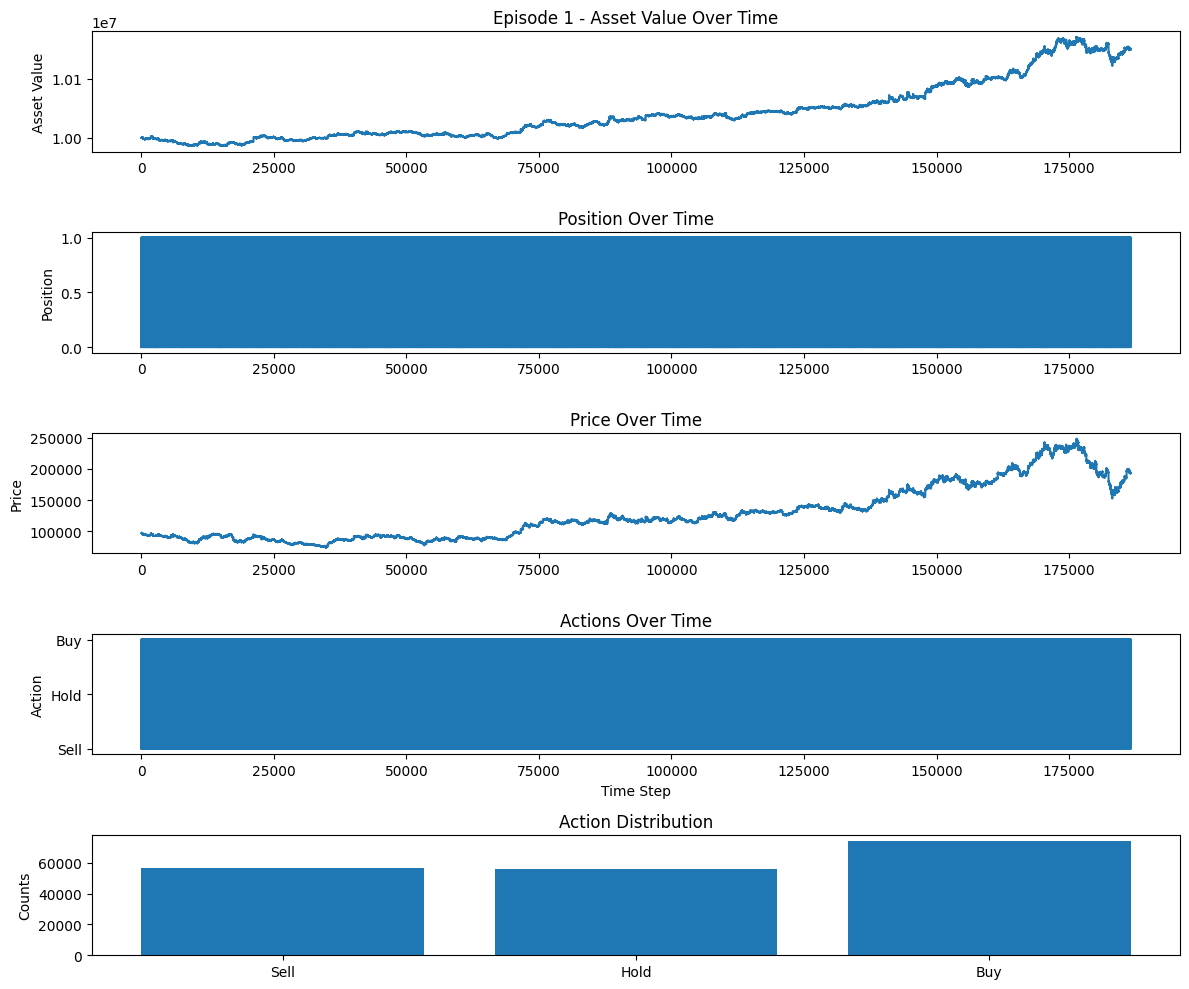

Episode 1 completed. Final Asset Value: 10148907.00
에피소드 1 시작!!!
Loss: 49742952.0000
Loss: 49742952.0000
Loss: 49742944.0000
Loss: 49742944.0000
Loss: 49742952.0000
Loss: 49742944.0000
Loss: 49742944.0000
Loss: 49742944.0000
Loss: 49742944.0000
Loss: 49742944.0000


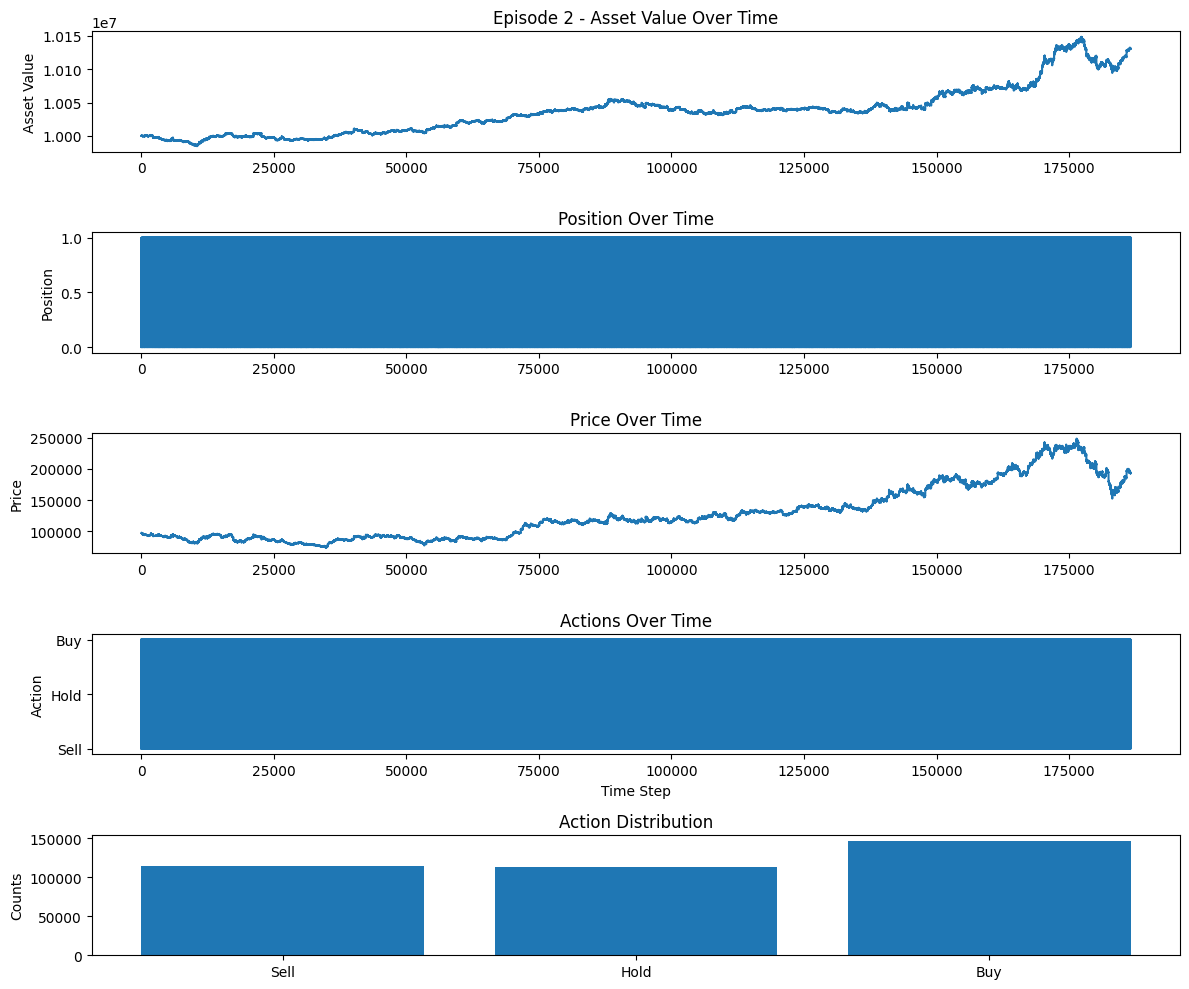

Episode 2 completed. Final Asset Value: 10130607.00
에피소드 2 시작!!!
Loss: 51720448.0000
Loss: 51720448.0000
Loss: 51720448.0000
Loss: 51720448.0000
Loss: 51720448.0000
Loss: 51720448.0000
Loss: 51720448.0000
Loss: 51720444.0000
Loss: 51720444.0000
Loss: 51720444.0000


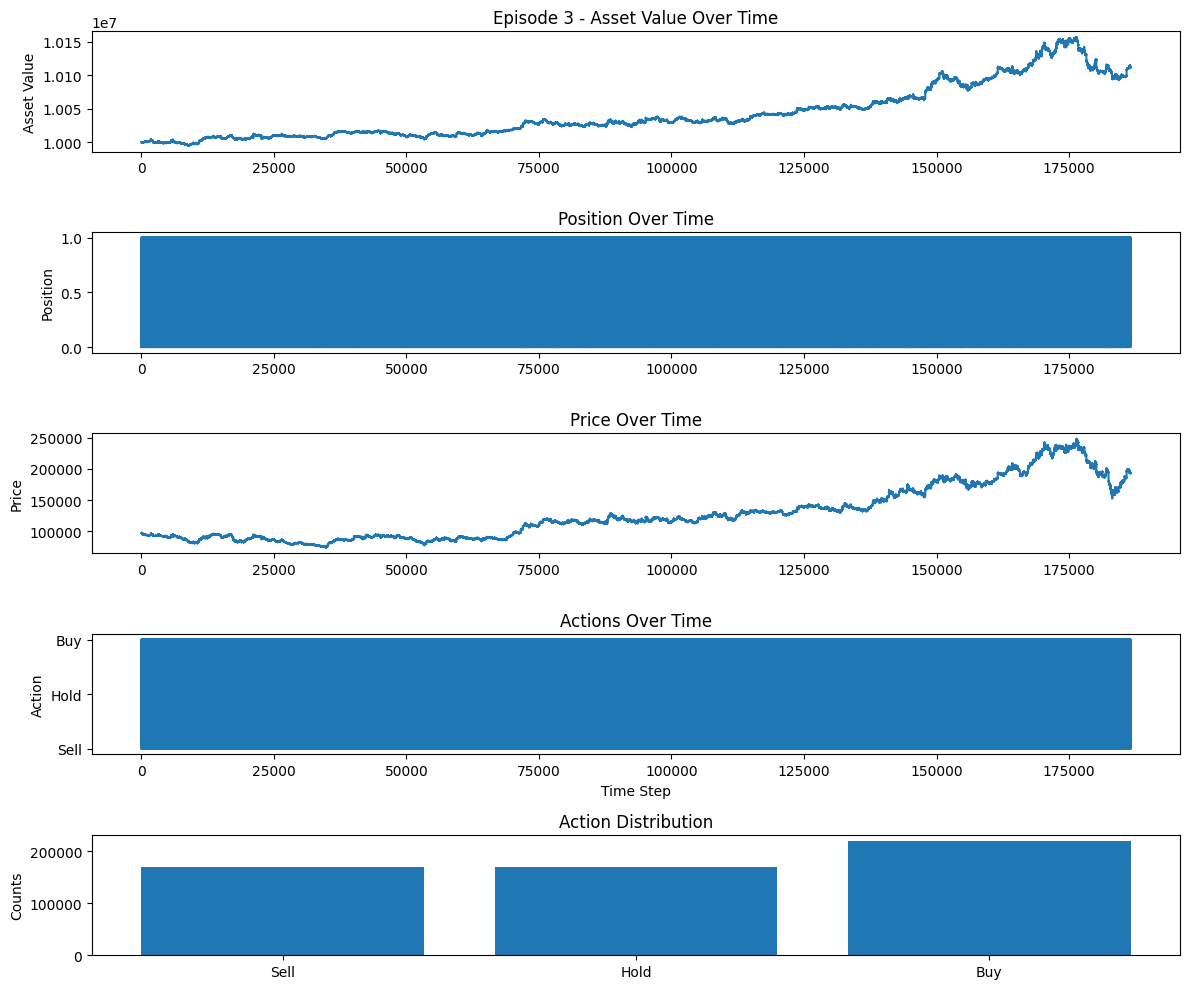

Episode 3 completed. Final Asset Value: 10111607.00
에피소드 3 시작!!!
Loss: 56018384.0000
Loss: 56018380.0000
Loss: 56018380.0000
Loss: 56018376.0000
Loss: 56018380.0000
Loss: 56018376.0000
Loss: 56018376.0000
Loss: 56018376.0000
Loss: 56018376.0000
Loss: 56018376.0000


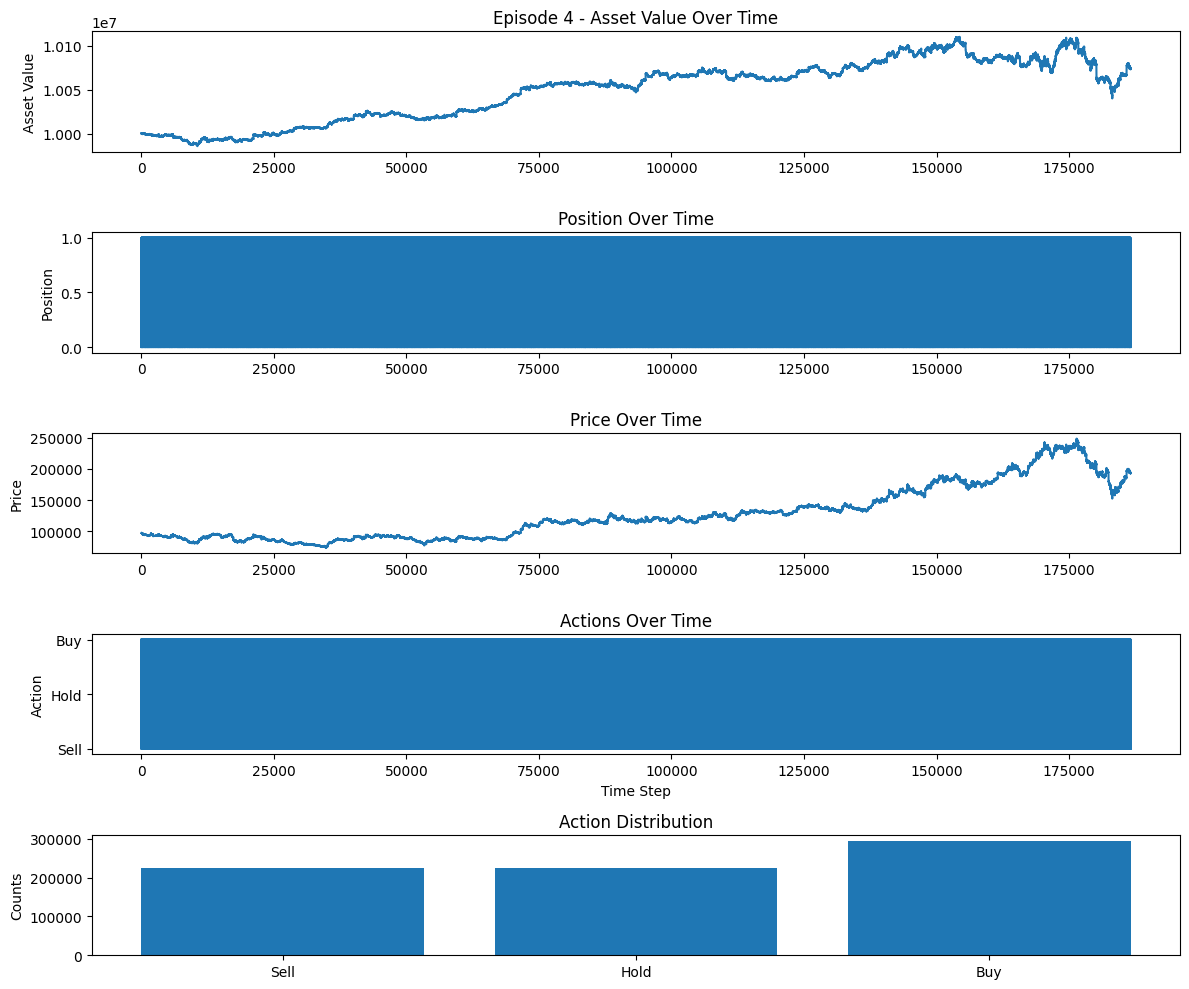

Episode 4 completed. Final Asset Value: 10073800.00
에피소드 4 시작!!!
Loss: 58715580.0000
Loss: 58715580.0000
Loss: 58715580.0000
Loss: 58715580.0000
Loss: 58715592.0000
Loss: 58715592.0000
Loss: 58715592.0000
Loss: 58715580.0000
Loss: 58715580.0000
Loss: 58715576.0000


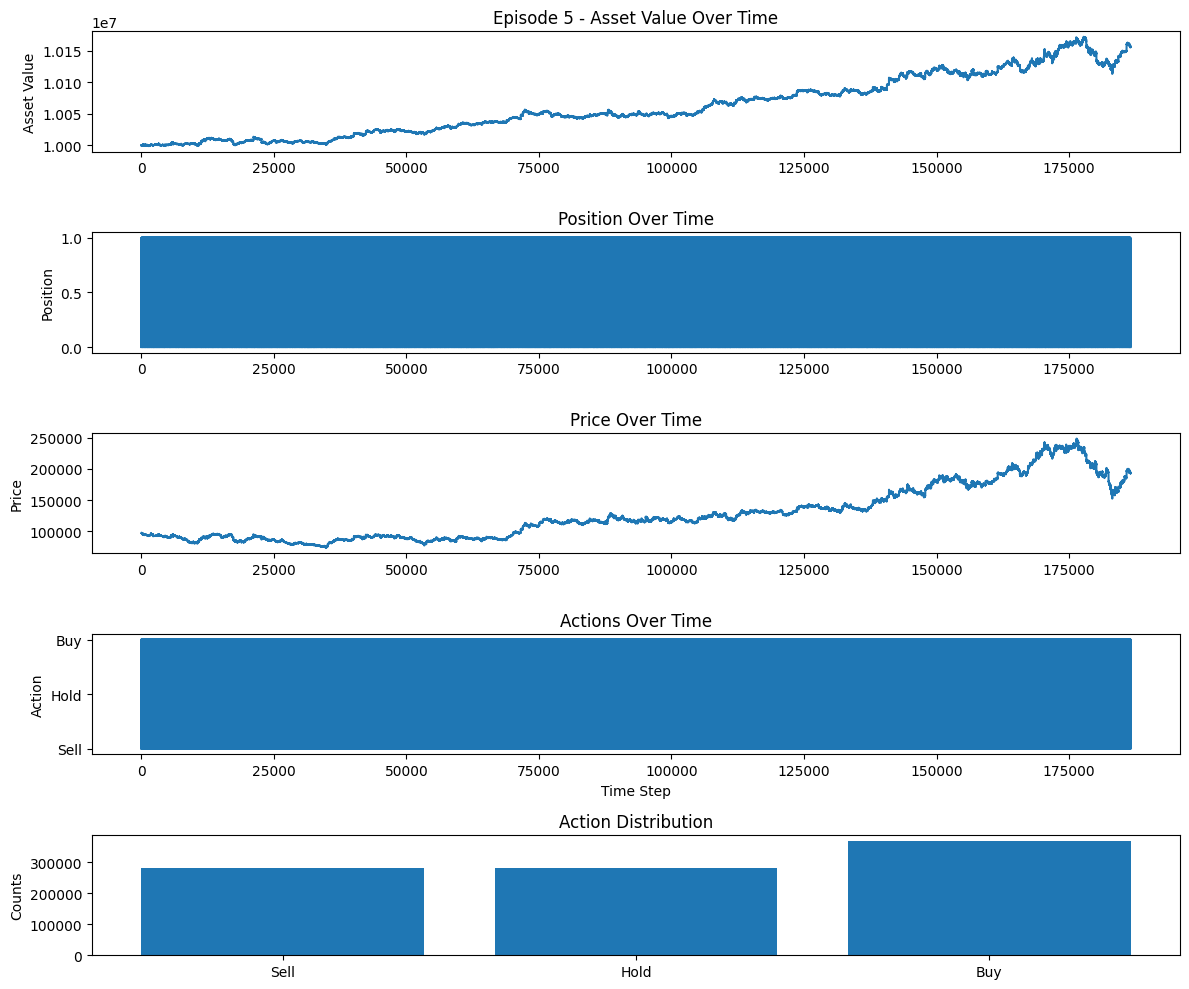

Episode 5 completed. Final Asset Value: 10155900.00
에피소드 5 시작!!!
Loss: 55270684.0000
Loss: 55270684.0000
Loss: 55270684.0000
Loss: 55270684.0000
Loss: 55270692.0000
Loss: 55270696.0000
Loss: 55270696.0000
Loss: 55270692.0000
Loss: 55270684.0000
Loss: 55270684.0000


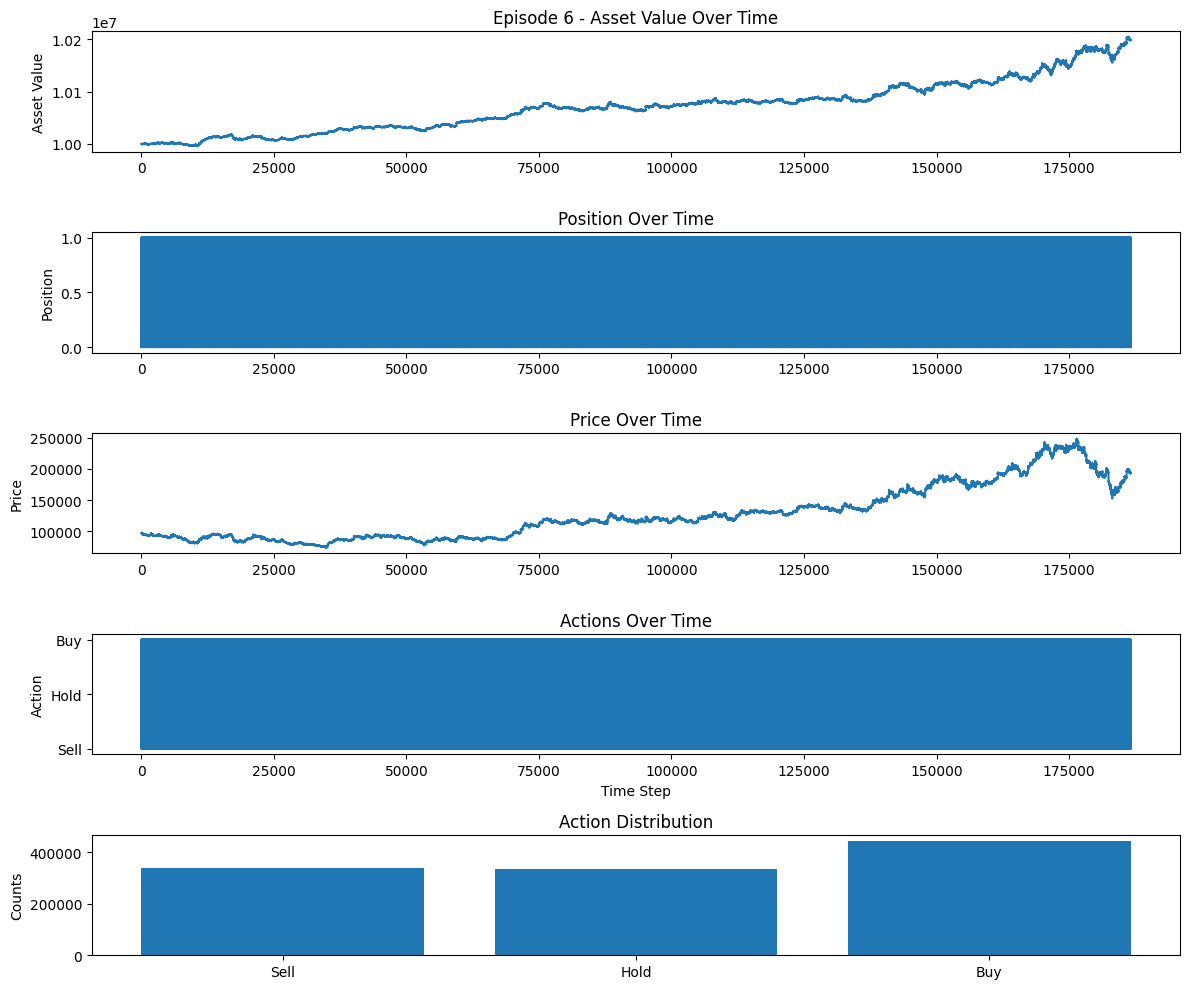

Episode 6 completed. Final Asset Value: 10198307.00
에피소드 6 시작!!!
Loss: 51571420.0000
Loss: 51571420.0000
Loss: 51571420.0000
Loss: 51571428.0000
Loss: 51571432.0000
Loss: 51571436.0000
Loss: 51571432.0000
Loss: 51571432.0000
Loss: 51571428.0000
Loss: 51571420.0000


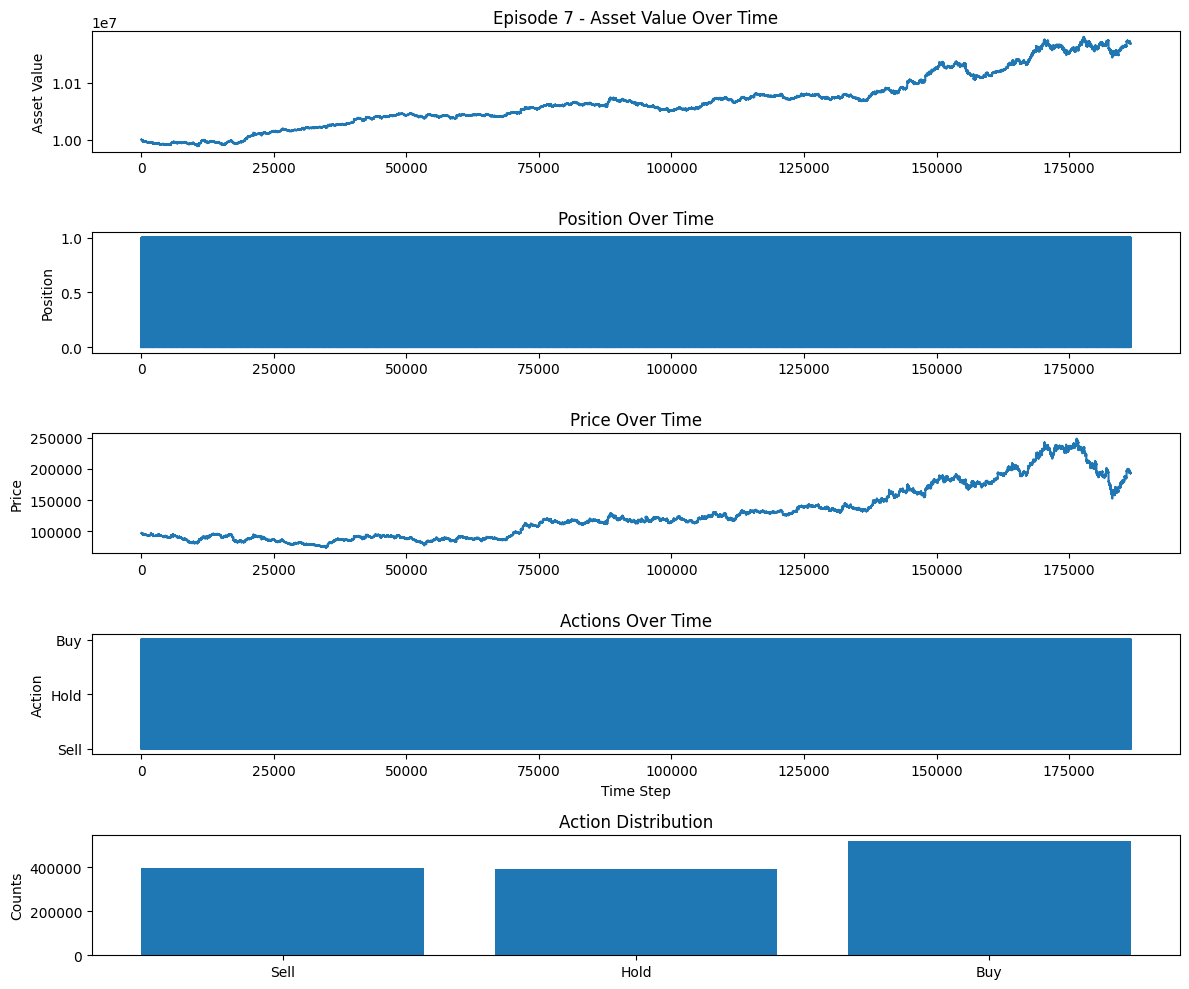

Episode 7 completed. Final Asset Value: 10168607.00
에피소드 7 시작!!!
Loss: 48809560.0000
Loss: 48809560.0000
Loss: 48809560.0000
Loss: 48809560.0000
Loss: 48809560.0000
Loss: 48809560.0000
Loss: 48809560.0000
Loss: 48809560.0000
Loss: 48809556.0000
Loss: 48809560.0000


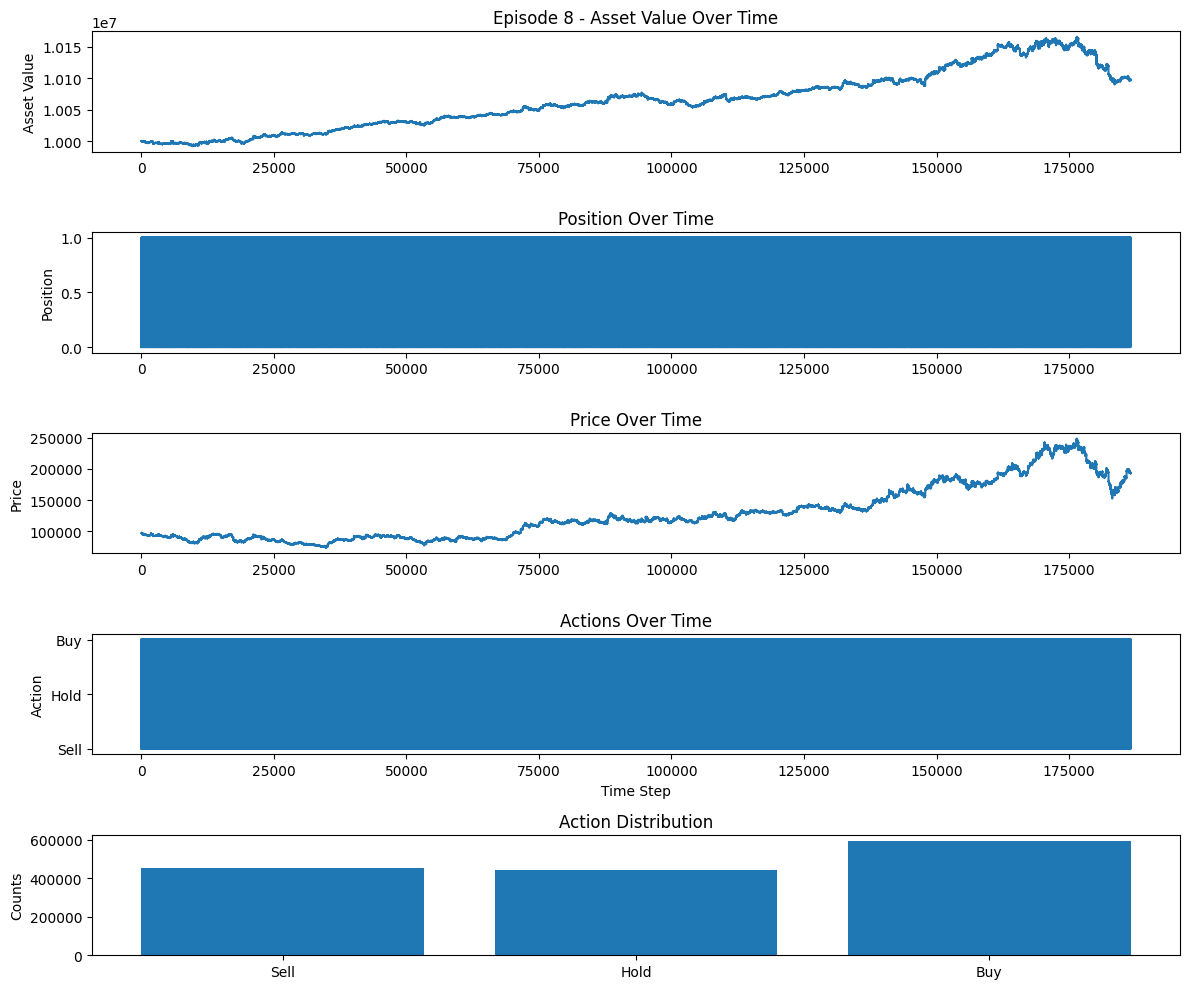

Episode 8 completed. Final Asset Value: 10096607.00
에피소드 8 시작!!!
Loss: 58434836.0000
Loss: 58434836.0000
Loss: 58434836.0000
Loss: 58434836.0000
Loss: 58434836.0000
Loss: 58434836.0000
Loss: 58434836.0000
Loss: 58434836.0000
Loss: 58434828.0000
Loss: 58434828.0000


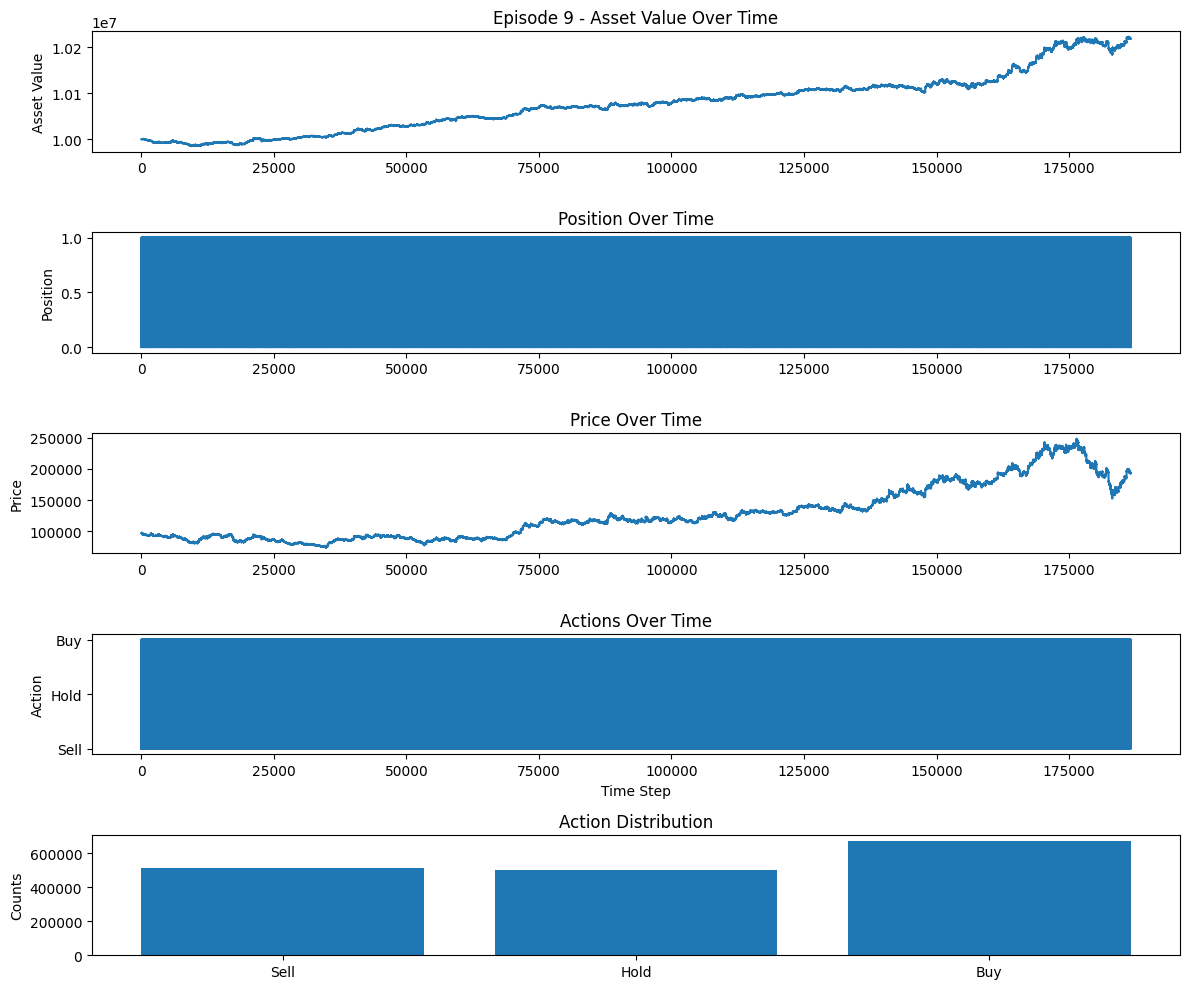

Episode 9 completed. Final Asset Value: 10219100.00
에피소드 9 시작!!!
Loss: 51397444.0000
Loss: 51397444.0000
Loss: 51397444.0000
Loss: 51397448.0000
Loss: 51397452.0000
Loss: 51397452.0000
Loss: 51397452.0000
Loss: 51397452.0000
Loss: 51397448.0000
Loss: 51397444.0000


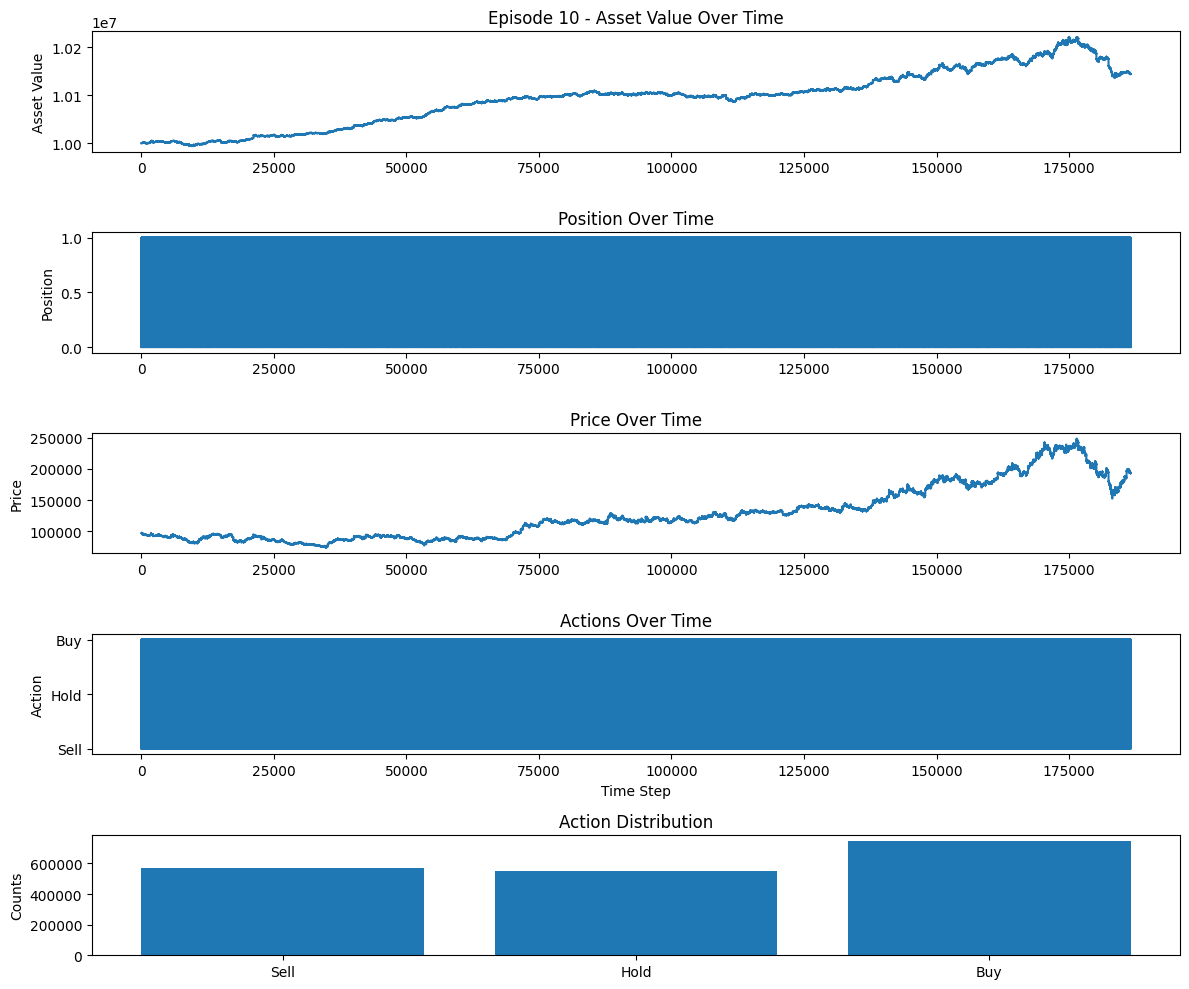

Episode 10 completed. Final Asset Value: 10144700.00


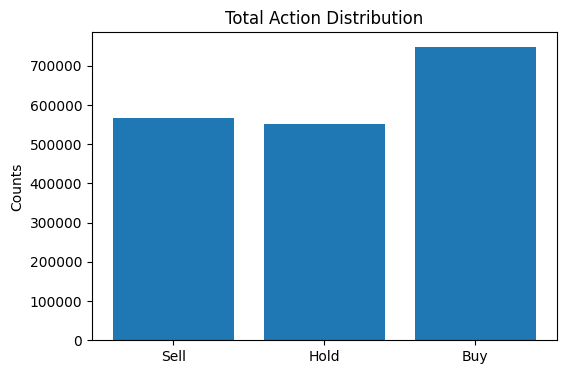

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import gym
from gym import spaces
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 데이터 로드 및 기술적 지표 계산
# df = yf.download('AAPL', start='2017-01-01', end='2020-12-31', progress=False)
df = pd.read_csv('./000660.csv')
df = df.rename(columns={'종가': 'Close'})

df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['RSI'] = 100 - (100 / (1 + df['Close'].diff().apply(lambda x: np.maximum(x, 0))
                          .rolling(window=14).mean() / df['Close'].diff()
                          .apply(lambda x: np.abs(np.minimum(x, 0)))
                          .rolling(window=14).mean()))
df = df.dropna().reset_index()

# 입력 데이터 정규화
scaler = StandardScaler()
feature_cols = ['Close', 'MA10', 'MA50', 'RSI']
scaler.fit(df[feature_cols])

# 주식 트레이딩 환경 정의
class StockTradingEnv(gym.Env):
    def __init__(self, df, scaler):
        super(StockTradingEnv, self).__init__()
        self.df = df
        self.scaler = scaler
        self.max_steps = len(df) - 1
        self.current_step = 0

        # 상태 공간: [현재 가격, MA10, MA50, RSI, 보유 여부]
        self.action_space = spaces.Discrete(3)  # 매도(0), 보유(1), 매수(2)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32
        )

        # 초기 자본금 및 포지션
        self.initial_balance = 10000000
        self.balance = self.initial_balance
        self.position = 0  # 0: 현금, 1: 주식 보유
        self.asset_value = self.initial_balance  # 포트폴리오 총 가치

        # 추적을 위한 리스트
        self.balance_history = []
        self.asset_value_history = []
        self.position_history = []
        self.action_history = []
        self.price_history = []

    def reset(self):
        self.balance = self.initial_balance
        self.position = 0
        self.asset_value = self.initial_balance
        self.current_step = 0

        # 히스토리 초기화
        self.balance_history = [self.balance]
        self.asset_value_history = [self.asset_value]
        self.position_history = [self.position]
        self.action_history = []
        self.price_history = [self.df.loc[self.current_step, 'Close']]

        return self._next_observation()

    def _next_observation(self):
        raw_state = self.df.loc[self.current_step, ['Close', 'MA10', 'MA50', 'RSI']]
        # Series를 DataFrame으로 변환
        raw_state_df = pd.DataFrame([raw_state])
        # scaler.transform에 DataFrame을 입력
        scaled_state = self.scaler.transform(raw_state_df)[0]
        frame = np.append(scaled_state, self.position)
        return frame.astype(np.float32)

    def step(self, action):
        done = False
        price = self.df.loc[self.current_step, 'Close']

        # 이전 포트폴리오 가치
        prev_asset_value = self.asset_value

        # 행동에 따른 포트폴리오 업데이트
        if action == 0:  # 매도
            if self.position == 1:
                self.balance += price
                self.position = 0
        elif action == 1:  # 보유
            pass
        elif action == 2:  # 매수
            if self.position == 0:
                self.balance -= price
                self.position = 1

        # 포트폴리오 가치 계산
        self.asset_value = self.balance + self.position * price

        # 보유 비용 적용 (포지션을 보유할 때마다 일정 비용 부과)
        holding_cost = 0
        if self.position == 1:
            holding_cost = 0.001 * price  # 가격의 0.1%를 보유 비용으로 설정
            self.asset_value -= holding_cost

        # 보상 계산: 포트폴리오 가치의 변화 (스케일링)
        reward = (self.asset_value - prev_asset_value) * 10  # 보상 스케일링

        self.current_step += 1
        if self.current_step >= self.max_steps:
            done = True

        # 히스토리 업데이트
        self.balance_history.append(self.balance)
        self.asset_value_history.append(self.asset_value)
        self.position_history.append(self.position)
        self.action_history.append(action)
        self.price_history.append(price)

        obs = self._next_observation()
        return obs, reward, done, {}

# 환경 생성
env = StockTradingEnv(df, scaler)

# PPO를 위한 액터-크리틱 신경망 정의
class ActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.policy_head = nn.Linear(128, action_dim)
        self.value_head = nn.Linear(128, 1)
        
        # 가중치 초기화
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.zeros_(module.bias)
    
    def forward(self, x):
        x = self.fc(x)
        policy_logits = self.policy_head(x)
        value = self.value_head(x)
        return policy_logits, value

    def act(self, state):
        # state = torch.FloatTensor(state)
        policy_logits, _ = self.forward(state)
        dist = Categorical(logits=policy_logits)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        return action.item(), action_logprob

    def evaluate(self, state, action):
        policy_logits, value = self.forward(state)
        dist = Categorical(logits=policy_logits)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        return action_logprobs, value.squeeze(-1), dist_entropy

# 하이퍼파라미터 설정
learning_rate = 1e-3  # 학습률 증가
gamma = 0.99
epsilon = 0.1         # 클리핑 파라미터 감소
epochs = 10
entropy_coef = 0.05   # 엔트로피 가중치 증가

# 정책 및 옵티마이저 초기화
input_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
# policy = ActorCritic(input_dim, action_dim)
policy = ActorCritic(input_dim, action_dim).to(device)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

# 메모리 클래스 정의
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

memory = Memory()

# PPO 업데이트 함수 정의
def ppo_update():
    # 리스트를 텐서로 변환
    states = torch.tensor(memory.states, dtype=torch.float32).to(device)
    actions = torch.tensor(memory.actions, dtype=torch.int64).to(device)
    old_logprobs = torch.tensor(memory.logprobs, dtype=torch.float32).to(device)
    rewards = memory.rewards
    is_terminals = memory.is_terminals

    # 리턴 계산
    returns = []
    discounted_reward = 0
    for reward, is_terminal in zip(reversed(rewards), reversed(is_terminals)):
        if is_terminal:
            discounted_reward = 0
        discounted_reward = reward + (gamma * discounted_reward)
        returns.insert(0, discounted_reward)
    returns = torch.tensor(returns, dtype=torch.float32).to(device)

    # 어드밴티지 계산
    with torch.no_grad():
        _, state_values = policy.forward(states)
        advantages = returns - state_values.squeeze(-1)

    # 정책 업데이트
    for _ in range(epochs):
        logprobs, state_values, dist_entropy = policy.evaluate(states, actions)
        ratios = torch.exp(logprobs - old_logprobs)
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - epsilon, 1 + epsilon) * advantages
        loss = -torch.min(surr1, surr2) + 0.5 * advantages.pow(2) - entropy_coef * dist_entropy  # 엔트로피 가중치 증가

        optimizer.zero_grad()
        loss.mean().backward()
        # 그레이디언트 클리핑
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=0.5)
        optimizer.step()

        # 손실 값 출력
        print(f"Loss: {loss.mean().item():.4f}")

# 학습 루프
max_episodes = 10  # 에피소드 수를 줄여 빠른 테스트
update_interval = 1

# 행동 분포 추적을 위한 리스트
action_counts = []

for episode in range(max_episodes):
    print(f'에피소드 {episode} 시작!!!')
    state = env.reset()
    done = False
    episode_actions = []
    while not done:
        state_tensor = torch.FloatTensor(state).to(device)
        action, action_logprob = policy.act(state_tensor)
        next_state, reward, done, _ = env.step(action)
        # 메모리에 데이터 저장
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(action_logprob.item())
        memory.rewards.append(reward)
        memory.is_terminals.append(done)
        state = next_state
        episode_actions.append(action)

    # 정책 업데이트 및 메모리 초기화
    ppo_update()
    memory.clear()

    # 행동 분포 추적
    action_counts.append(np.bincount(episode_actions, minlength=3))

    # 에피소드별 성과 시각화
    plt.figure(figsize=(12, 10))

    # 포트폴리오 가치 변화 시각화
    plt.subplot(5, 1, 1)
    plt.plot(env.asset_value_history)
    plt.title(f'Episode {episode+1} - Asset Value Over Time')
    plt.ylabel('Asset Value')

    # 포지션 변화 시각화
    plt.subplot(5, 1, 2)
    plt.plot(env.position_history)
    plt.title('Position Over Time')
    plt.ylabel('Position')

    # 주가 변화 시각화
    plt.subplot(5, 1, 3)
    plt.plot(env.price_history)
    plt.title('Price Over Time')
    plt.ylabel('Price')

    # 행동 시각화
    plt.subplot(5, 1, 4)
    plt.plot(env.action_history)
    plt.title('Actions Over Time')
    plt.ylabel('Action')
    plt.xlabel('Time Step')
    plt.yticks([0, 1, 2], ['Sell', 'Hold', 'Buy'])

    # 행동 분포 시각화
    plt.subplot(5, 1, 5)
    counts = np.array(action_counts).sum(axis=0)
    plt.bar(['Sell', 'Hold', 'Buy'], counts)
    plt.title('Action Distribution')
    plt.ylabel('Counts')

    plt.tight_layout()
    plt.show()

    print(f"Episode {episode+1} completed. Final Asset Value: {env.asset_value_history[-1]:.2f}")

# 전체 행동 분포 시각화
total_counts = np.array(action_counts).sum(axis=0)
plt.figure(figsize=(6, 4))
plt.bar(['Sell', 'Hold', 'Buy'], total_counts)
plt.title('Total Action Distribution')
plt.ylabel('Counts')
plt.show()